# TF-Ranking Model

### The TF-Ranking DNN Model is used in this project - it requires data in Example List With Context (ELWC) Format, which will be created by example_columns. In this Ranking situation, since dense representations include the query and the doc, we will leave the example_column empty.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!pip install transformers
!pip install tensorflow
!pip install bert-tensorflow
!pip install tensorflow_ranking

     |████████████████████████████████| 757kB 11.3MB/s 
     |████████████████████████████████| 3.0MB 47.9MB/s 
     |████████████████████████████████| 1.1MB 50.8MB/s 
     |████████████████████████████████| 890kB 52.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=62146dedbd301641ae6247b9fec951cfe87a9731adeda5eb96def564085f39b1
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 71kB 5.7MB/s 
     |████████████████████████████████| 92kB 6.0MB/s 


In [3]:
import pandas as pd
from transformers import TFBertModel, BertTokenizer
import bert.tokenization as tokenization
import tensorflow as tf
import tensorflow_ranking as tfr
import itertools
import numpy as np
import time
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, ReduceLROnPlateau, LearningRateScheduler, EarlyStopping, TensorBoard
from tensorflow.keras.callbacks import LambdaCallback, CSVLogger

In [4]:
list_size = 10
batch_size = 5
number_of_features = 768
valid_set_ratio = 0.15
seed = 1234
trial = f'tfrbert_1_{seed}'
np.random.seed(seed)
tf.random.set_seed(seed)

In [5]:
# Reading the pre-processed data into a dataframe

added_train_df = pd.read_csv('./drive/My Drive/Antique_Dataset/added_antique_train_bert.tsv', sep='\t')
train_df = pd.read_csv('./drive/My Drive/Antique_Dataset/antique_train_bert.tsv', sep='\t')
test_df = pd.read_csv('./drive/My Drive/Antique_Dataset/antique_test_bert.tsv', sep='\t')

In [6]:
train_df

,query_id,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
0,2531329,U0,2531329_0,4,Why do some men spit into the urinal before ur...,I do it all the time. It is kind of a ritual ...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.05681726, 0.2980671, -0.12610446, -0.366616..."
1,2531329,Q0,2531329_5,4,Why do some men spit into the urinal before ur...,To clear out the mucus deep down in the throat...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.40824068, 0.6845711, -0.53848433, -0.36029..."
2,2531329,Q0,2531329_4,3,Why do some men spit into the urinal before ur...,"maybe they want a target to hit. Well, I gues...","[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.52939916, 0.5299391, -0.4963811, -0.319871..."
3,2531329,Q0,2531329_7,3,Why do some men spit into the urinal before ur...,Where else would we spit?... Apart from sports...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.2236495, 0.45706183, -0.39957872, -0.45759..."
4,2531329,Q0,2531329_6,3,Why do some men spit into the urinal before ur...,Because they have a cough or phlegm and hacked...,"[101, 2339, 2079, 2070, 2273, 13183, 2046, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.26474723, 0.3622378, -0.37632445, -0.52224..."
...,...,...,...,...,...,...,...,...,...,...
27401,884731,U0,884731_0,4,What does the word Padre mean in english?,Padre is a word used in both Spanish and Portu...,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.5623697, 0.4166778, -0.59484327, -0.324400..."
27402,884731,Q0,884731_4,4,What does the word Padre mean in english?,Father,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[-0.28291002, 0.19619924, 0.1452271, -0.223253..."
27403,884731,Q0,884731_2,4,What does the word Padre mean in english?,"the word padre in english means ""father""","[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.64837384, 0.5308057, -0.57113624, -0.39678..."
27404,884731,Q0,884731_3,4,What does the word Padre mean in english?,Father.,"[101, 2054, 2515, 1996, 2773, 28612, 2812, 199...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[-0.37813485, 0.2946631, 0.05168551, -0.246607..."


In [7]:
test_df.head()

,query_id,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
0,1964316,U0,1964316_5,4,"What do you mean by ""weed""?",Weed could mean the bad thing that grow in ur ...,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.117683396, 0.38120887, -0.8148023, -0.2977..."
1,1964316,Q0,1674088_11,1,"What do you mean by ""weed""?",sell weed,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[-0.18537731, 0.26467037, -0.7377305, -0.18130..."
2,1964316,Q0,1218838_13,2,"What do you mean by ""weed""?",My weed!!,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.00073738396, 0.24537405, -0.50234264, -0.4..."
3,1964316,Q0,1519022_15,2,"What do you mean by ""weed""?",because we dont know what the hell to make leg...,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.31584862, 0.08820932, -0.56504595, -0.2485..."
4,1964316,Q0,3059341_5,2,"What do you mean by ""weed""?",Its a weed.,"[101, 2054, 2079, 2017, 2812, 2011, 1000, 1790...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[-0.13292149, 0.30342782, -0.52649224, -0.3847..."


In [8]:
def group_by_query(test_df):
  unique_queries = test_df['query_id'].unique()
  result = pd.DataFrame()
  for query_id in unique_queries:
      test = test_df.loc[test_df['query_id'] == query_id]
      query = test['query'].iloc[0]
      total = test.count()[0]
      number = list_size - (total % list_size)
      for i in range(number):
          line = pd.DataFrame({'query_id': query_id,
                              'source': 'Generated',
                                'doc_id': '-1',
                              'relevance': '-1',
                                'doc': 'filler',
                              'query': str(query),
                              'input_ids': str([-1 for _ in range(512)]),
                              'token_type_ids': str([-1 for _ in range(512)]),
                              'attention_mask': str([0 for _ in range(512)]),
                              'bert_embeddings': str([-1 for _ in range(number_of_features)])
                              }, index=[i])
          test = test.append(line, ignore_index=False)
      test = test.sample(frac=1).reset_index(drop=True)
      result = result.append(test, ignore_index=False)
  result.reset_index(drop=True, inplace=True)
  return result

In [9]:
added_valid_index = (int(len(added_train_df) * (1 - valid_set_ratio) // list_size) * list_size)
print(added_valid_index)
added_vali_df = added_train_df[added_valid_index:len(added_train_df)]
added_vali_df.reset_index(drop= True, inplace=True)
added_train_df = added_train_df[0:added_valid_index]

38530


In [10]:
valid_index = (int(len(train_df) * (1 - valid_set_ratio) // list_size) * list_size)
print(valid_index)
vali_df = train_df[valid_index:len(train_df)]
vali_df.reset_index(drop= True, inplace=True)
train_df = train_df[0:valid_index]

23290


In [11]:
test_df = group_by_query(test_df)

In [12]:
print(len(added_train_df))
print(len(added_vali_df))
print(len(train_df))
print(len(vali_df))
print(len(test_df))

38530
6810
23290
4116
7720


In [13]:
# Showing the average number of documents per query
added_train_df.groupby(['query_id']).count().describe()

,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
count,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000,2095.000000
mean,18.391408,18.391408,18.391408,18.391408,18.391408,18.391408,18.391408,18.391408,18.391408
std,14.136716,14.136716,14.136716,14.136716,14.136716,14.136716,14.136716,14.136716,14.136716
min,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
25%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
50%,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
75%,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
max,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000,160.000000


In [14]:
# Showing number of documents per query_id
added_train_df.groupby('query_id').count()

,source,doc_id,relevance,query,doc,input_ids,token_type_ids,attention_mask,bert_embeddings
query_id,,,,,,,,,
751,20,20,20,20,20,20,20,20,20
1763,20,20,20,20,20,20,20,20,20
2704,40,40,40,40,40,40,40,40,40
3961,30,30,30,30,30,30,30,30,30
4409,10,10,10,10,10,10,10,10,10
...,...,...,...,...,...,...,...,...,...
4473502,10,10,10,10,10,10,10,10,10
4477752,10,10,10,10,10,10,10,10,10
4477858,20,20,20,20,20,20,20,20,20


In [15]:
# Distribution of relevance scores per data
added_train_df['relevance'].value_counts(normalize=True)

1    0.421853
4    0.259201
3    0.177316
2    0.141630
Name: relevance, dtype: float64

In [16]:
added_vali_df['relevance'].value_counts(normalize=True)

1    0.433480
4    0.255066
3    0.182819
2    0.128634
Name: relevance, dtype: float64

In [17]:
# -1 is the examples that are padded
test_df['relevance'].value_counts(normalize=True)

2     0.313083
1     0.212694
4     0.172798
3     0.154922
-1    0.146503
Name: relevance, dtype: float64

In [18]:
def convert_dflist_to_array(series, start):
  array = np.array(series[start])
  for i in range(start+1,start+len(series)):
    array = np.vstack((array, np.array(series[i])))
  return array

In [19]:
# Generator to yield n examples for 1 list for list_wise comparison

def generator(dataframe, mode):
    length = len(dataframe)
    for i in itertools.count(0, list_size):
        step = i%length
        if step+list_size > length:
            if mode == 'test':
                return
            else:
                continue
        if mode == 'test' and i>length:
          return
        array = dataframe['bert_embeddings'][step:step+list_size].apply(lambda data: list(map(lambda x: float(x), data.strip('][').split(', '))))
        array = convert_dflist_to_array(array, step)
        bert_tensor = tf.constant(array)
        labels = tf.constant(dataframe['relevance'][step:step+list_size].astype('int32'))
        yield ({'example_list': bert_tensor}, labels)
        

In [20]:
# Converting the dataframe into a dataset for Keras training

def df_to_dataset(dataframe, batch_size=8, mode='train'):
    dataframe = dataframe.copy()
    dataframe = dataframe.filter(['query_id', 'bert_embeddings', 'relevance'])
    dataset = tf.data.Dataset.from_generator(
        lambda: generator(dataframe, mode),
        output_types = ({
            'example_list': tf.float32,
        },
        tf.float32
        ),
        output_shapes = ({
            'example_list': tf.TensorShape([list_size, 768])
        },
        tf.TensorShape(list_size)
        )
    )
    if mode == 'train':
        return dataset.shuffle(len(dataframe), reshuffle_each_iteration=False).batch(batch_size, drop_remainder=True)
    elif mode == 'test':
        return dataset.batch(batch_size, drop_remainder=True)

In [21]:
added_train_dataset = df_to_dataset(added_train_df, batch_size, mode='train')

In [22]:
added_vali_dataset = df_to_dataset(added_vali_df, batch_size, mode='train')

In [23]:
train_dataset = df_to_dataset(train_df, batch_size, mode='train')

In [24]:
vali_dataset = df_to_dataset(vali_df, batch_size, mode='train')

In [25]:
test_dataset = df_to_dataset(test_df, 1, mode='test')

In [26]:
list(added_train_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(5, 10, 768), dtype=float32, numpy=
   array([[[-0.7622967 ,  0.40911207, -0.40409997, ..., -0.66209024,
             0.6379686 ,  0.49087065],
           [-0.06332202, -0.07800333,  0.11533423, ...,  0.14967611,
             0.10714296, -0.09922576],
           [-0.7201666 ,  0.5257171 , -0.3449874 , ..., -0.75787044,
             0.54836255,  0.56451076],
           ...,
           [-0.73570013,  0.40454972, -0.44220483, ..., -0.8338623 ,
             0.3480812 ,  0.24750164],
           [-0.05657485, -0.19467306,  0.38044325, ...,  0.67741436,
            -0.12551907,  0.11917455],
           [-0.20052794, -0.11798409,  0.09222409, ..., -0.40529716,
             0.19990733,  0.2897965 ]],
   
          [[-0.10535818,  0.5140592 , -0.30021945, ..., -0.1623317 ,
             0.69136477,  0.68749505],
           [-0.5161778 ,  0.4434309 , -0.75251603, ..., -0.41203636,
             0.7030272 ,  0.3157836 ],
           [-0.58219916,  0.4986898 , -0.7

In [27]:
list(train_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(5, 10, 768), dtype=float32, numpy=
   array([[[-0.18968944,  0.28414702, -0.11884687, ..., -0.86627805,
             0.5533538 ,  0.29857817],
           [-0.20198545,  0.3931365 , -0.35243842, ..., -0.450943  ,
             0.623665  ,  0.60425466],
           [-0.14175965,  0.20546132,  0.024126  , ..., -0.63279825,
             0.41184807,  0.5866674 ],
           ...,
           [-0.46176904,  0.33664045, -0.43156835, ..., -0.6872599 ,
             0.604813  ,  0.5729249 ],
           [-0.31045055,  0.25500208, -0.44469196, ..., -0.6696809 ,
             0.5458633 ,  0.47244644],
           [ 0.20649439,  0.2816046 , -0.36790144, ..., -0.533556  ,
             0.3326514 ,  0.7051772 ]],
   
          [[-0.39904383,  0.01918707, -0.28124547, ..., -0.8777137 ,
             0.3383457 ,  0.27885383],
           [-0.05545785, -0.03856687, -0.60390353, ..., -0.698459  ,
             0.13611089,  0.6550308 ],
           [-0.09061896,  0.16715598, -0.4

In [28]:
list(test_dataset.take(1))

[({'example_list': <tf.Tensor: shape=(1, 10, 768), dtype=float32, numpy=
   array([[[-0.23987323,  0.18608159, -0.6528367 , ..., -0.871925  ,
             0.62816346,  0.29636678],
           [-1.        , -1.        , -1.        , ..., -1.        ,
            -1.        , -1.        ],
           [-0.14427444,  0.17517442, -0.69948053, ..., -0.9871173 ,
             0.40628037,  0.44368178],
           ...,
           [ 0.0691073 ,  0.15568088, -0.5939702 , ..., -0.7165735 ,
             0.5951419 ,  0.5289375 ],
           [-0.06951316,  0.17805326, -0.7463974 , ..., -0.76655555,
             0.6494951 ,  0.34199873],
           [-0.14201826,  0.1795239 , -0.5834667 , ..., -0.9952638 ,
             0.47768563,  0.21595344]]], dtype=float32)>},
  <tf.Tensor: shape=(1, 10), dtype=float32, numpy=array([[ 4., -1.,  2.,  1.,  2.,  4.,  2.,  2.,  3.,  2.]], dtype=float32)>)]

In [29]:
# Defining what 1 example is: A dense representation of query-doc pair in the form of
# an array of 768 values

def example_feature_columns():
    embedding_column = tf.feature_column.numeric_column(key='example_list',
                                                       shape=(number_of_features))
    example_feature_columns = {'example_list': embedding_column}
    
    
    return example_feature_columns

In [30]:
# Using the TF-Ranking library and their DNN Network
def get_ranker():

  network = tfr.keras.canned.DNNRankingNetwork(
      context_feature_columns={},
      example_feature_columns=example_feature_columns(),
      hidden_layer_dims=[1024, 512, 256],
      activation=tf.nn.relu,
      dropout=0.5
  )
  # Using Softmax loss for list_wise inference and NDCG for metrics

  #softmax_loss_obj = tfr.keras.losses.get(tfr.losses.RankingLossKey.SOFTMAX_LOSS)
  softmax_loss_obj = tfr.keras.losses.get(tfr.losses.RankingLossKey.SOFTMAX_LOSS)
  default_metrics = tfr.keras.metrics.default_keras_metrics()

  ranker = tfr.keras.model.create_keras_model(
    network=network,
    loss=softmax_loss_obj,
    metrics=default_metrics,
    optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.05),
    size_feature_name = None
  )

  return ranker

In [31]:
# network = tfr.keras.canned.GAMRankingNetwork(
#     context_feature_columns=None,
#     example_feature_columns=example_feature_columns(),
#     example_hidden_layer_dims=[1024, 512, 256],
#     activation=tf.nn.relu,
#     dropout=0.5,
#     use_batch_norm=True,
#     batch_norm_moment=0.999,
#     name="gam_ranking_network")

## DCG - Discounted Cumulative Gain
DCG is based on the premise that highly relevant documents appearing lower in a search result list should be penalized as the graded relevance value is reduced logarithmically propotional to the result.
### DCG at rank position $p$ is defined as:
### $DCG_p$ = $rel_1$ + $\sum_{i=2}^{p} \frac{2^{rel_i} - 1}{log_2(i+1)}$	

where $rel_i$ is the graded relevance (label) of the result at position $i$

## NDCG - Normalized Discounted Cumulative Gain

Since search results lists vary in length depending on query, a more consistent approach is to use NDCG where NDCG is defined by sorting all relevant documents by their relative relevance to produce the maximum possible DCG through position $p$ (also known as the Ideal DCG (IDCG)), and taking the search result's DCG divided by the IDCG.

### $nDCG_p$ = $\frac{DCG_p}{IDCG_p}$

This means that NDCG@n is the fraction of the DCG of the top n computed search results divided over the DCG of the top n relevant search results.

In [32]:
ranker = get_ranker()

In [33]:
ranker.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
example_list (InputLayer)    [(None, None, 768)]       0         
_________________________________________________________________
dnn_ranking_network (DNNRank (None, None)              1454081   
Total params: 1,454,081
Trainable params: 1,448,961
Non-trainable params: 5,120
_________________________________________________________________


In [34]:
ranker.get_config()

{'input_layers': {'example_list': ['example_list', 0, 0]},
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, None, 768),
    'dtype': 'float32',
    'name': 'example_list',
    'ragged': False,
    'sparse': False},
   'inbound_nodes': [],
   'name': 'example_list'},
  {'class_name': 'DNNRankingNetwork',
   'config': {'activation': 'relu',
    'batch_norm_moment': 0.999,
    'context_feature_columns': {},
    'dropout': 0.5,
    'dtype': 'float32',
    'example_feature_columns': {'example_list': {'class_name': 'NumericColumn',
      'config': {'default_value': None,
       'dtype': 'float32',
       'key': 'example_list',
       'normalizer_fn': None,
       'shape': (768,)}}},
    'hidden_layer_dims': ListWrapper([1024, 512, 256]),
    'name': 'dnn_ranking_network',
    'trainable': True,
    'use_batch_norm': True},
   'inbound_nodes': [{'example_list': ['example_list', 0, 0, {'mask': None}]}],
   'name': 'dnn_ranking_network'}],
 'name': 'model',
 'o

In [35]:
checkpoint = ModelCheckpoint(f'./drive/My Drive/Antique_Dataset/checkpoints/best_weights_added_{trial}.hdf5', monitor='val_metric/ndcg_5', verbose=1, save_best_only=True, mode='max')
tsv = CSVLogger(f'./drive/My Drive/Antique_Dataset/outputs/training_stats_added_{trial}.tsv', separator='\t', append=False)

In [36]:
added_hist = ranker.fit(
    added_train_dataset,
    validation_data=added_vali_dataset,
    verbose=1,
    steps_per_epoch = int(len(added_train_df) / (batch_size * list_size)),
    epochs=20,
    validation_steps = int(len(added_vali_df) / (batch_size * list_size)),
    callbacks = [checkpoint, tsv]
)

Epoch 1/20
769/770 [============================>.] - ETA: 0s - loss: 50.9404 - metric/ndcg_1: 0.7622 - metric/ndcg_3: 0.7911 - metric/ndcg_5: 0.8446 - metric/ndcg_10: 0.9058 - metric/arp: 4.5106 - metric/ordered_pair_accuracy: 0.8358 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 32.8121 - metric/ndcg: 0.9058
Epoch 00001: val_metric/ndcg_5 improved from -inf to 0.87361, saving model to ./drive/My Drive/Antique_Dataset/checkpoints/best_weights_added_tfrbert_1_1234.hdf5
770/770 [==============================] - 59s 77ms/step - loss: 50.9330 - metric/ndcg_1: 0.7626 - metric/ndcg_3: 0.7911 - metric/ndcg_5: 0.8447 - metric/ndcg_10: 0.9059 - metric/arp: 4.5103 - metric/ordered_pair_accuracy: 0.8359 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 32.8100 - metric/ndcg: 0.9059 - val_loss: 50.3634 - val_metric/ndcg_1: 0.8175 - val_metric/ndcg_3: 0.8315 - val_metric/ndcg_5: 0.8736 - val_metric/ndcg_10: 0.9244 - val_metric/a

In [37]:
added_result_last = ranker.evaluate(test_dataset)

773/773 [==============================] - 12s 15ms/step - loss: 42.9597 - metric/ndcg_1: 0.6244 - metric/ndcg_3: 0.6772 - metric/ndcg_5: 0.7508 - metric/ndcg_10: 0.8487 - metric/arp: 4.5445 - metric/ordered_pair_accuracy: 0.6574 - metric/mrr: 1.0000 - metric/precision: 0.8536 - metric/map: 1.0000 - metric/dcg: 25.4826 - metric/ndcg: 0.8487


In [38]:
ranker.load_weights(f'./drive/My Drive/Antique_Dataset/checkpoints/best_weights_added_{trial}.hdf5')

In [39]:
added_result = ranker.evaluate(test_dataset)

773/773 [==============================] - 11s 15ms/step - loss: 42.9597 - metric/ndcg_1: 0.6247 - metric/ndcg_3: 0.6772 - metric/ndcg_5: 0.7508 - metric/ndcg_10: 0.8487 - metric/arp: 4.5445 - metric/ordered_pair_accuracy: 0.6574 - metric/mrr: 1.0000 - metric/precision: 0.8536 - metric/map: 1.0000 - metric/dcg: 25.4848 - metric/ndcg: 0.8486


In [40]:
ranker = get_ranker()

In [41]:
checkpoint = ModelCheckpoint(f'./drive/My Drive/Antique_Dataset/checkpoints/best_weights_{trial}.hdf5', monitor='val_metric/ndcg_5', verbose=1, save_best_only=True, mode='max')
tsv = CSVLogger(f'./drive/My Drive/Antique_Dataset/outputs/training_stats_{trial}.tsv', separator='\t', append=False)

In [42]:
hist = ranker.fit(
    train_dataset,
    validation_data=vali_dataset,
    verbose=1,
    steps_per_epoch = int(len(train_df) / (batch_size * list_size)),
    epochs=20,
    validation_steps = int(len(vali_df) / (batch_size * list_size)),
    callbacks = [checkpoint, tsv]
)

Epoch 1/20
465/465 [==============================] - ETA: 0s - loss: 72.6657 - metric/ndcg_1: 0.7095 - metric/ndcg_3: 0.7309 - metric/ndcg_5: 0.7657 - metric/ndcg_10: 0.8897 - metric/arp: 5.2928 - metric/ordered_pair_accuracy: 0.6345 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 43.1838 - metric/ndcg: 0.8897
Epoch 00001: val_metric/ndcg improved from -inf to 0.91611, saving model to ./drive/My Drive/Antique_Dataset/checkpoints/best_weights_tfrbert_1_1234.hdf5
465/465 [==============================] - 36s 78ms/step - loss: 72.6657 - metric/ndcg_1: 0.7095 - metric/ndcg_3: 0.7309 - metric/ndcg_5: 0.7657 - metric/ndcg_10: 0.8897 - metric/arp: 5.2928 - metric/ordered_pair_accuracy: 0.6345 - metric/mrr: 1.0000 - metric/precision: 1.0000 - metric/map: 1.0000 - metric/dcg: 43.1838 - metric/ndcg: 0.8897 - val_loss: 72.1412 - val_metric/ndcg_1: 0.8023 - val_metric/ndcg_3: 0.7943 - val_metric/ndcg_5: 0.8143 - val_metric/ndcg_10: 0.9161 - val_metric/arp: 5.21

In [43]:
result_last = ranker.evaluate(test_dataset)

773/773 [==============================] - 12s 15ms/step - loss: 42.8978 - metric/ndcg_1: 0.5880 - metric/ndcg_3: 0.6474 - metric/ndcg_5: 0.7261 - metric/ndcg_10: 0.8341 - metric/arp: 4.6032 - metric/ordered_pair_accuracy: 0.6227 - metric/mrr: 1.0000 - metric/precision: 0.8536 - metric/map: 1.0000 - metric/dcg: 25.1110 - metric/ndcg: 0.8341


In [44]:
ranker.load_weights(f'./drive/My Drive/Antique_Dataset/checkpoints/best_weights_{trial}.hdf5')

In [45]:
result = ranker.evaluate(test_dataset)

773/773 [==============================] - 12s 15ms/step - loss: 42.9021 - metric/ndcg_1: 0.5699 - metric/ndcg_3: 0.6452 - metric/ndcg_5: 0.7205 - metric/ndcg_10: 0.8307 - metric/arp: 4.6126 - metric/ordered_pair_accuracy: 0.6209 - metric/mrr: 1.0000 - metric/precision: 0.8536 - metric/map: 1.0000 - metric/dcg: 24.9867 - metric/ndcg: 0.8306


# Results

We got 0.7257 for nDCG_5, using the best saved model (lowest validation loss) which is decent, but a far cry from the validation metric of val_ndcg_5 of 0.8839. Part of the reason is that the training data is grouped in lists of 10, and all query-doc pairs are based on the same query, but for the test data, it is not based on the same query as data can't be made up for the test dataset. 

This is also an improvement from a separate run where additional irrelevant data was not created to balance the bias in the training dataset, where that run achieve 0.7044 nDCG_5 for the test dataset. 

In [46]:
import matplotlib.pyplot as plt
def plot_train(hist):
    h = hist.history
    i = 0
    for metric in h.keys():
        if 'val' in metric:
            return
        plt.figure(i)
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+metric])
        plt.title('model '+metric)
        plt.ylabel(metric)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'])
        i += 1

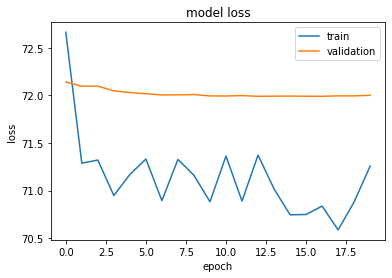

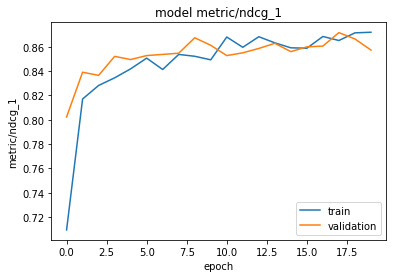

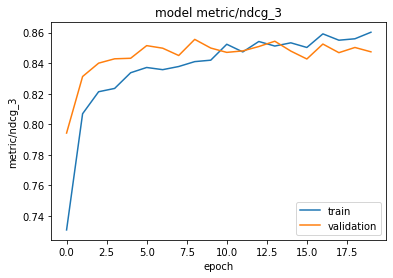

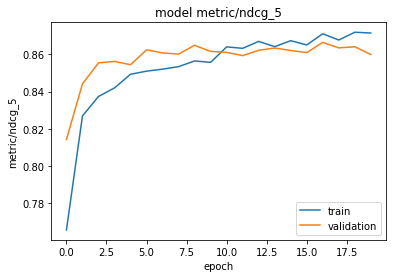

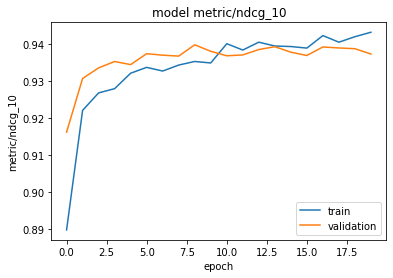

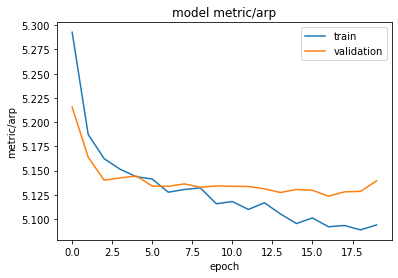

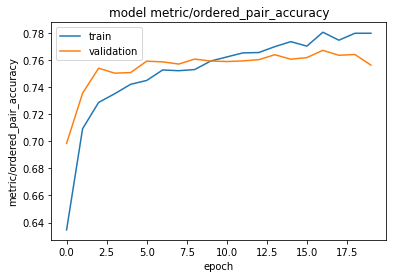

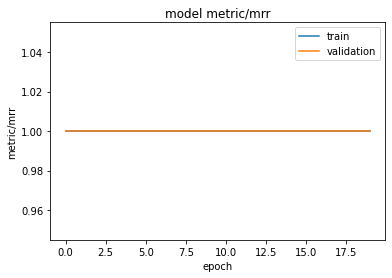

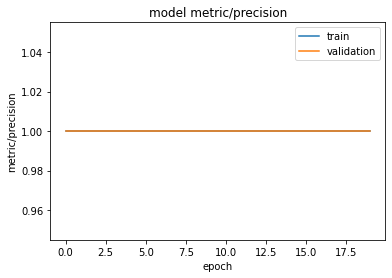

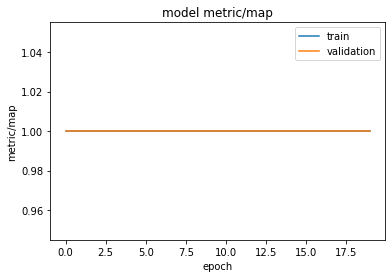

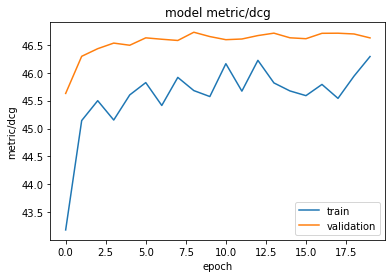

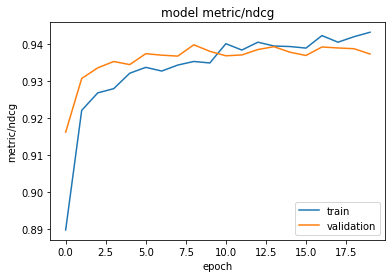

In [47]:
plot_train(hist)

In [48]:
result

[42.902095794677734,
 0.5699390769004822,
 0.6452277898788452,
 0.7204871773719788,
 0.8306686282157898,
 4.612631320953369,
 0.6209359169006348,
 1.0,
 0.8535577058792114,
 1.0,
 24.986730575561523,
 0.8306270241737366]